In [4]:
from typing import List, Tuple, Sequence

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context("notebook", font_scale=1.)
sns.set_style("darkgrid")

In [5]:
def plot_ts(ts, title):
    """ Plot a time series. """
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(ts.index, ts, lw=2, label='O3 concentration')
    ax.set_title(title, fontsize=30)
    ax.set_ylabel('{} values'.format(ts.name), fontsize=23)
    ax.set_xlabel('Timestamp', fontsize=23)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    fig.autofmt_xdate()

    return fig, ax


def plot_ma(ax, ts, ma_period):
    """ Plot a moving average for a time series in the given axes. """
    ma = ts.rolling(window=ma_period).mean()
    ax.plot(ts.index, ma, lw=1, label='{}-days MA'.format(ma_period))
    return ax


def plot_ts_ma(ts, ma_period, title):
    """ Plot a time series with its moving average given by the specified period. """
    fig, ax = plot_ts(ts, title)
    plot_ma(ax, ts, ma_period)
    ax.legend(fontsize=15)

    return fig, ax


def plot_ts_standard_mas(ts, title):
    """ Plot a time series with its moving average for 10, 20 and 50 days period. """
    ma_periods = [10, 25, 50]
    fig, ax = plot_ts(ts, title)
    for ma in ma_periods:
        plot_ma(ax, ts, ma)
    ax.legend(fontsize=15)

    return fig, ax


def plot_3d_clusters(data:np.array, y_kmeans:np.array):
    """ Plot clusters of data with 3 dimensions."""
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=y_kmeans, cmap='viridis')
    return fig, ax


def plot_ts_clusters_scatter(df, title):
    """ Plot clusters of data over time for O3 pollutant measures. """
    clusters = df.groupby('y')
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    for name, c in clusters:
        ax.scatter(c.index, c['O3'], label='Cluster {}'.format(name))

    ax.set_title(title, fontsize=30)
    ax.set_ylabel('NO2 values', fontsize=23)
    ax.set_xlabel('Timestamp', fontsize=23)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    ax.legend(fontsize=15)

    fig.autofmt_xdate()
    
    return fig, ax

In [6]:
def load_data(features:List) -> pd.DataFrame:
    """ Load the data set from the Huairou monitoring site and process
    it with a timestamp index, selecting the list of features passed as
    argument, upsampling to daily frequency measures and fillin the
    missing values with cubic interpolation. """
    
    print('Data: features={}'.format(features))
    df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')
    df.index = pd.to_datetime({'Year': df['Year'],
                                       'Month': df['Month'],
                                       'Day': df['Day'],
                                       'Hour': df['Hour']})
    return pd.DataFrame(
        data=df[features].values, 
        index=df.index, 
        columns=features, 
        dtype=np.float32
    ).sort_index().resample('D').mean().interpolate(method='cubic')


def scale_data(data: np.ndarray) -> np.ndarray:
    """ Interface for scaling a data set. In the current version,
    standard scaling is done with scikit-learn. """
    
    return StandardScaler().fit_transform(data)
    
    
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """ Interface for pre-processing the data.
    Add pre-processing steps here. """
    
    df.loc[:] = scale_data(data=df.values)
    print('Data after pre-processing:')
    print(df)
    return df


def create_fit_model(x: np.ndarray, init: str, n_clusters: int, n_init: int):
    """ Interface for creating and tRaining a model. In the current
    version, k-means is used with scikit-learn. """
    
    print('Model parameters: init={}, n_clusters={}, n_init={}'
          .format(init, n_clusters, n_init))
    model = KMeans(init=init, n_clusters=n_clusters, n_init=n_init)
    model.fit(x)
    return model

    
def evaluate_model(name: str, model, x: np.ndarray) -> List:
    """ Interface for evaluating a model. In the current version,
    a k-means model is evaluated with scikit-learn. Silhouette Coefficient
    and Calinski-Harabasz index are used as evaluation metrics. """
    
    silhouette = metrics.silhouette_score(x, model.labels_,metric='euclidean')
    calinski = metrics.calinski_harabasz_score(x, model.labels_)
    print('init\t\tnfeat\tclusters inertia silhouette calinski')
    print('%-9s\t%i\t%i\t%i\t%.3f\t%.3f'
          % (name, x.shape[1], model.cluster_centers_.shape[0],
             model.inertia_, silhouette, calinski))
    return [name, x.shape[1], model.cluster_centers_.shape[0],
            model.inertia_, silhouette, calinski]


def test(name: str = '_', features: List = ['O3', 'Temp', 'WinSpeed'], n_clusters: int = 4,
         init: str = 'k-means++', n_init: int = 10) -> Tuple[List, pd.DataFrame]:
    """ Performs a test given the arguments and returns the model evaluation
    results alongside the data used with the cluster labels. Loads data,
    pre-process data, creates and fits a model and evaluates the model. """
    
    print(40 * '_' + name + 40 * '_')
    print('LOADING DATA')
    df = load_data(features=features)
    print('PRE-PROCESSING DATA')
    df = preprocess_data(df=df)
    print('MODELLING')
    model = create_fit_model(x=df.values, init=init, n_clusters=n_clusters, n_init=n_init)
    print('EVALUATING')
    res = evaluate_model(name=name, model=model, x=df.values)
    df['y'] = model.predict(df)
    return (res, df)


def experiment(tests: Tuple[str, List] = [('default',['O3', 'Temp', 'WinSpeed'])],
               clusters: Sequence = range(3, 6)):
    """ Performs a grid search hyperparameter tuning for the features
    and clusters specified as arguments. """
    
    res_list = []
    data_list = []
    for name, features in tests:
        for c in clusters:
            res, data = test(features=features, n_clusters=c, name=name)
            res_list.append(res)
            data_list.append(data)
    results = pd.DataFrame(res_list, columns=['name', 'nfeat', 'clusters',
                                              'inertia', 'silhouette', 'calinski'])
    return results, data_list

In [7]:
# Testing the code with a default experiment. Click 'Output' to show logs.
results, data_list = experiment()
results

________________________________________default________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp  WinSpeed
2013-03-01  0.296962 -1.142359  1.689868
2013-03-02 -0.669627 -1.226816 -0.831676
2013-03-03 -0.938106 -0.764858 -0.379230
2013-03-04 -0.010593 -0.362383  0.707429
2013-03-05  0.607686 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.245105
2017-02-25  0.040363 -0.600023  0.457004
2017-02-26 -0.406508 -0.625093 -0.183138
2017-02-27 -0.805302 -0.534153 -0.290816
2017-02-28  0.046072 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	3	1541	0.439	1343.334
________________________________________default________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp  WinSpeed
2013-03-01  0.296962 -1.142359  1.689868
2013-03-02 -0.669627 -1.226816 -0.831676
2013-03-03 -0.938106 -0.764858 -0.379230
2013-03-04 -0.010593 -0.362383  0.707429
2013-03-05  0.607686 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.245105
2017-02-25  0.040363 -0.600023  0.457004
2017-02-26 -0.406508 -0.625093 -0.183138
2017-02-27 -0.805302 -0.534153 -0.290816
2017-02-28  0.046072 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	4	1190	0.378	1302.388
________________________________________default________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp  WinSpeed
2013-03-01  0.296962 -1.142359  1.689868
2013-03-02 -0.669627 -1.226816 -0.831676
2013-03-03 -0.938106 -0.764858 -0.379230
2013-03-04 -0.010593 -0.362383  0.707429
2013-03-05  0.607686 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.245105
2017-02-25  0.040363 -0.600023  0.457004
2017-02-26 -0.406508 -0.625093 -0.183138
2017-02-27 -0.805302 -0.534153 -0.290816
2017-02-28  0.046072 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	5	993	0.373	1241.095


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


,name,nfeat,clusters,inertia,silhouette,calinski
0,default,3,3,1541.839600,0.439383,1343.334120
1,default,3,4,1190.498657,0.378011,1302.387924
2,default,3,5,993.967407,0.372586,1241.094807


In [8]:
tests = [('O3', ['O3', 'Temp', 'WinSpeed']),
         ('with Press', ['O3', 'Temp', 'Press', 'WinSpeed']),
         ('with DewP', ['O3', 'Temp', 'DewP', 'WinSpeed']),
         ('with Rain', ['O3', 'Temp', 'Rain', 'WinSpeed']),
         ('with Press DewP', ['O3', 'Temp', 'Press', 'DewP', 'WinSpeed']),
         ('with Press Rain', ['O3', 'Temp', 'Press', 'Rain', 'WinSpeed']),
         ('with DewP Rain', ['O3', 'Temp', 'DewP', 'Rain', 'WinSpeed']),
         ('all', ['O3', 'Temp', 'Press', 'DewP', 'Rain', 'WinSpeed'])]
clusters = range(2, 6)

# Click 'Output' to show logs.
results, data_list = experiment(tests=tests, clusters=clusters)

________________________________________O3________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp  WinSpeed
2013-03-01  0.296962 -1.142359  1.689868
2013-03-02 -0.669627 -1.226816 -0.831676
2013-03-03 -0.938106 -0.764858 -0.379230
2013-03-04 -0.010593 -0.362383  0.707429
2013-03-05  0.607686 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.245105
2017-02-25  0.040363 -0.600023  0.457004
2017-02-26 -0.406508 -0.625093 -0.183138
2017-02-27 -0.805302 -0.534153 -0.290816
2017-02-28  0.046072 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
O3       	3	2	2474	0.407	1124.914
________________________________________O3________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp  WinSpeed
2013-03-01  0.296962 -1.142359  1.689868
2013-03-02 -0.669627 -1.226816 -0.831676
2013-03-03 -0.938106 -0.764858 -0.379230
2013-03-04 -0.010593 -0.362383  0.707429
2013-03-05  0.607686 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.245105
2017-02-25  0.040363 -0.600023  0.457004
2017-02-26 -0.406508 -0.625093 -0.183138
2017-02-27 -0.805302 -0.534153 -0.290816
2017-02-28  0.046072 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
O3       	3	3	1541	0.439	1343.334
________________________________________O3________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp  WinSpeed
2013-03-01  0.296962 -1.142359  1.689868
2013-03-02 -0.669627 -1.226816 -0.831676
2013-03-03 -0.938106 -0.764858 -0.379230
2013-03-04 -0.010593 -0.362383  0.707429
2013-03-05  0.607686 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.245105
2017-02-25  0.040363 -0.600023  0.457004
2017-02-26 -0.406508 -0.625093 -0.183138
2017-02-27 -0.805302 -0.534153 -0.290816
2017-02-28  0.046072 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
O3       	3	4	1190	0.379	1302.402
________________________________________O3________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp  WinSpeed
2013-03-01  0.296962 -1.142359  1.689868
2013-03-02 -0.669627 -1.226816 -0.831676
2013-03-03 -0.938106 -0.764858 -0.379230
2013-03-04 -0.010593 -0.362383  0.707429
2013-03-05  0.607686 -0.637901 -1.049502
...              ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.245105
2017-02-25  0.040363 -0.600023  0.457004
2017-02-26 -0.406508 -0.625093 -0.183138
2017-02-27 -0.805302 -0.534153 -0.290816
2017-02-28  0.046072 -0.294041  0.547394

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
O3       	3	5	994	0.369	1241.025
________________________________________with Press________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Press', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068  0.245105
2017-02-25  0.040363 -0.600023  0.639554  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.290816
2017-02-28  0.046072 -0.294041  0.253628  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	2	2986	0.431	1395.864
________________________________________with Press________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Press', 'WinSpeed'

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068  0.245105
2017-02-25  0.040363 -0.600023  0.639554  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.290816
2017-02-28  0.046072 -0.294041  0.253628  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	3	2112	0.418	1287.995
________________________________________with Press________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Press', 'WinSpeed'

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068  0.245105
2017-02-25  0.040363 -0.600023  0.639554  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.290816
2017-02-28  0.046072 -0.294041  0.253628  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	4	1710	0.335	1173.579
________________________________________with Press________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Press', 'WinSpeed'

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068  0.245105
2017-02-25  0.040363 -0.600023  0.639554  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.290816
2017-02-28  0.046072 -0.294041  0.253628  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	5	1484	0.343	1069.150


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with DewP________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'DewP', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      DewP  WinSpeed
2013-03-01  0.296962 -1.142359 -1.675220  1.689868
2013-03-02 -0.669627 -1.226816 -1.388242 -0.831676
2013-03-03 -0.938106 -0.764858 -1.096097 -0.379230
2013-03-04 -0.010593 -0.362383 -1.129254  0.707429
2013-03-05  0.607686 -0.637901 -0.769715 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -1.024025  0.245105
2017-02-25  0.040363 -0.600023 -0.967349  0.457004
2017-02-26 -0.406508 -0.625093 -0.776321 -0.183138
2017-02-27 -0.805302 -0.534153 -0.709826 -0.290816
2017-02-28  0.046072 -0.294041 -1.092421  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	2	2988	0.434	1394.429
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      DewP  WinSpeed
2013-03-01  0.296962 -1.142359 -1.675220  1.689868
2013-03-02 -0.669627 -1.226816 -1.388242 -0.831676
2013-03-03 -0.938106 -0.764858 -1.096097 -0.379230
2013-03-04 -0.010593 -0.362383 -1.129254  0.707429
2013-03-05  0.607686 -0.637901 -0.769715 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -1.024025  0.245105
2017-02-25  0.040363 -0.600023 -0.967349  0.457004
2017-02-26 -0.406508 -0.625093 -0.776321 -0.183138
2017-02-27 -0.805302 -0.534153 -0.709826 -0.290816
2017-02-28  0.046072 -0.294041 -1.092421  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	3	2049	0.420	1349.789
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      DewP  WinSpeed
2013-03-01  0.296962 -1.142359 -1.675220  1.689868
2013-03-02 -0.669627 -1.226816 -1.388242 -0.831676
2013-03-03 -0.938106 -0.764858 -1.096097 -0.379230
2013-03-04 -0.010593 -0.362383 -1.129254  0.707429
2013-03-05  0.607686 -0.637901 -0.769715 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -1.024025  0.245105
2017-02-25  0.040363 -0.600023 -0.967349  0.457004
2017-02-26 -0.406508 -0.625093 -0.776321 -0.183138
2017-02-27 -0.805302 -0.534153 -0.709826 -0.290816
2017-02-28  0.046072 -0.294041 -1.092421  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	4	1589	0.359	1299.606
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      DewP  WinSpeed
2013-03-01  0.296962 -1.142359 -1.675220  1.689868
2013-03-02 -0.669627 -1.226816 -1.388242 -0.831676
2013-03-03 -0.938106 -0.764858 -1.096097 -0.379230
2013-03-04 -0.010593 -0.362383 -1.129254  0.707429
2013-03-05  0.607686 -0.637901 -0.769715 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -1.024025  0.245105
2017-02-25  0.040363 -0.600023 -0.967349  0.457004
2017-02-26 -0.406508 -0.625093 -0.776321 -0.183138
2017-02-27 -0.805302 -0.534153 -0.709826 -0.290816
2017-02-28  0.046072 -0.294041 -1.092421  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	5	1306	0.379	1264.442
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      Rain  WinSpeed
2013-03-01  0.296962 -1.142359 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.212377 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -0.212377  0.245105
2017-02-25  0.040363 -0.600023 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041 -0.212377  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	2	3901	0.378	726.215
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      Rain  WinSpeed
2013-03-01  0.296962 -1.142359 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.212377 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -0.212377  0.245105
2017-02-25  0.040363 -0.600023 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041 -0.212377  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	3	2969	0.395	705.739


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Rain________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Rain', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      Rain  WinSpeed
2013-03-01  0.296962 -1.142359 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.212377 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -0.212377  0.245105
2017-02-25  0.040363 -0.600023 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041 -0.212377  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	4	2158	0.400	829.119
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      Rain  WinSpeed
2013-03-01  0.296962 -1.142359 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.212377 -1.049502
...              ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -0.212377  0.245105
2017-02-25  0.040363 -0.600023 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041 -0.212377  0.547394

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	5	1751	0.419	850.418
________________________________________with Press DewP________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Press', 'DewP',

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      DewP  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -1.675220  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -1.388242 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -1.096097 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -1.129254  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.769715 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -1.024025  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.967349  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.776321 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.709826 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -1.092421  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	2	3534	0.443	1556.352
____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      DewP  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -1.675220  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -1.388242 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -1.096097 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -1.129254  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.769715 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -1.024025  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.967349  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.776321 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.709826 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -1.092421  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	3	2605	0.401	1315.262
____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      DewP  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -1.675220  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -1.388242 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -1.096097 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -1.129254  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.769715 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -1.024025  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.967349  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.776321 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.709826 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -1.092421  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	4	2108	0.322	1197.270
____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      DewP  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -1.675220  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -1.388242 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -1.096097 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -1.129254  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.769715 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -1.024025  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.967349  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.776321 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.709826 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -1.092421  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	5	1788	0.341	1122.938


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Press Rain________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Press', 'Rain', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      Rain  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -0.212377  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	2	4410	0.405	957.358


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Press Rain________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Press', 'Rain', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      Rain  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -0.212377  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	3	3534	0.382	777.528
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      Rain  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -0.212377  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	4	2723	0.386	816.824
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      Rain  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -0.212377  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	5	2313	0.317	785.140
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      DewP      Rain  WinSpeed
2013-03-01  0.296962 -1.142359 -1.675220 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816 -1.388242 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858 -1.096097 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383 -1.129254 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -1.024025 -0.212377  0.245105
2017-02-25  0.040363 -0.600023 -0.967349 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093 -0.776321 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153 -0.709826 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041 -1.092421 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	2	4404	0.408	960.741


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with DewP Rain________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'DewP', 'Rain', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      DewP      Rain  WinSpeed
2013-03-01  0.296962 -1.142359 -1.675220 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816 -1.388242 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858 -1.096097 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383 -1.129254 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -1.024025 -0.212377  0.245105
2017-02-25  0.040363 -0.600023 -0.967349 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093 -0.776321 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153 -0.709826 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041 -1.092421 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	3	3465	0.382	807.539
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      DewP      Rain  WinSpeed
2013-03-01  0.296962 -1.142359 -1.675220 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816 -1.388242 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858 -1.096097 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383 -1.129254 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -1.024025 -0.212377  0.245105
2017-02-25  0.040363 -0.600023 -0.967349 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093 -0.776321 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153 -0.709826 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041 -1.092421 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	4	2655	0.387	850.345
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp      DewP      Rain  WinSpeed
2013-03-01  0.296962 -1.142359 -1.675220 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816 -1.388242 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858 -1.096097 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383 -1.129254 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040 -1.024025 -0.212377  0.245105
2017-02-25  0.040363 -0.600023 -0.967349 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093 -0.776321 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153 -0.709826 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041 -1.092421 -0.212377  0.547394

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	5	2191	0.332	849.609
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      DewP      Rain  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -1.675220 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -1.388242 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -1.096097 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -1.129254 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -1.024025 -0.212377  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.967349 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.776321 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.709826 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -1.092421 -0.212377  0.547394

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________all________________________________________
LOADING DATA
Data: features=['O3', 'Temp', 'Press', 'DewP', 'Rain', 'WinSpeed']


C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      DewP      Rain  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -1.675220 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -1.388242 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -1.096097 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -1.129254 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -1.024025 -0.212377  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.967349 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.776321 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.709826 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -1.092421 -0.212377  0.547394

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      DewP      Rain  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -1.675220 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -1.388242 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -1.096097 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -1.129254 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -1.024025 -0.212377  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.967349 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.776321 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.709826 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -1.092421 -0.212377  0.547394

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\956714787.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset.csv')


PRE-PROCESSING DATA
Data after pre-processing:
                  O3      Temp     Press      DewP      Rain  WinSpeed
2013-03-01  0.296962 -1.142359  1.578879 -1.675220 -0.212377  1.689868
2013-03-02 -0.669627 -1.226816  1.577173 -1.388242 -0.212377 -0.831676
2013-03-03 -0.938106 -0.764858  0.345547 -1.096097 -0.212377 -0.379230
2013-03-04 -0.010593 -0.362383  0.649821 -1.129254 -0.212377  0.707429
2013-03-05  0.607686 -0.637901 -0.020205 -0.769715 -0.212377 -1.049502
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.309168 -0.800040  0.858068 -1.024025 -0.212377  0.245105
2017-02-25  0.040363 -0.600023  0.639554 -0.967349 -0.212377  0.457004
2017-02-26 -0.406508 -0.625093  0.789199 -0.776321 -0.212377 -0.183138
2017-02-27 -0.805302 -0.534153  0.473105 -0.709826 -0.212377 -0.290816
2017-02-28  0.046072 -0.294041  0.253628 -1.092421 -0.212377  0.547394

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


{'whiskers': [<matplotlib.lines.Line2D at 0x1ac64de8940>,
 'caps': [<matplotlib.lines.Line2D at 0x1ac64de89a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ac64de8790>],
 'medians': [<matplotlib.lines.Line2D at 0x1ac64de87c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ac64de9330>],
 'means': []}

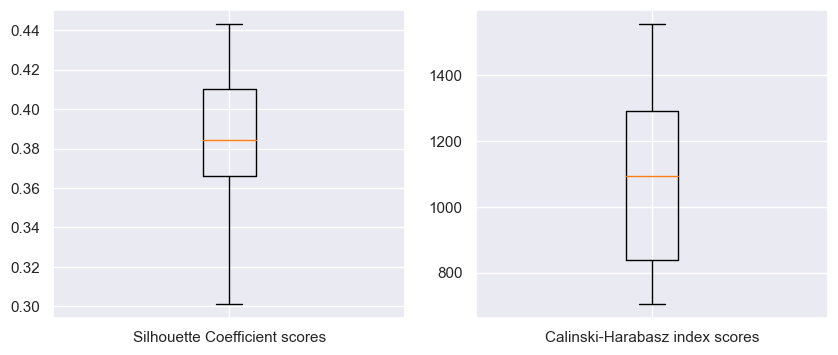

In [9]:
fig = plt.figure(figsize=(10, 4))
ax1, ax2 = fig.subplots(1, 2)
ax1.boxplot(results['silhouette'], labels=['Silhouette Coefficient scores'])
ax2.boxplot(results['calinski'], labels=['Calinski-Harabasz index scores'])

In [10]:
results.shape

(32, 6)

In [11]:
best_results = results.loc[(results['silhouette'] > 0.4) & (results['calinski'] > 1100)].sort_values(by='silhouette', ascending=False)
print(best_results)


               name  nfeat  clusters      inertia  silhouette     calinski
16  with Press DewP      5         2  3534.577148    0.443291  1556.352250
1                O3      3         3  1541.839600    0.439383  1343.334120
8         with DewP      4         2  2988.128418    0.433803  1394.429247
4        with Press      4         2  2986.620850    0.430519  1395.863555
9         with DewP      4         3  2049.402344    0.419698  1349.788991
28              all      6         2  4956.825195    0.418832  1121.198418
5        with Press      4         3  2112.189697    0.418435  1287.994571
0                O3      3         2  2474.849365    0.406935  1124.914167
17  with Press DewP      5         3  2605.020996    0.400772  1315.261754


C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\987009407.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\987009407.py:70: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\987009407.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\987009407.py:70: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_28268\987009407.py:67: Matpl

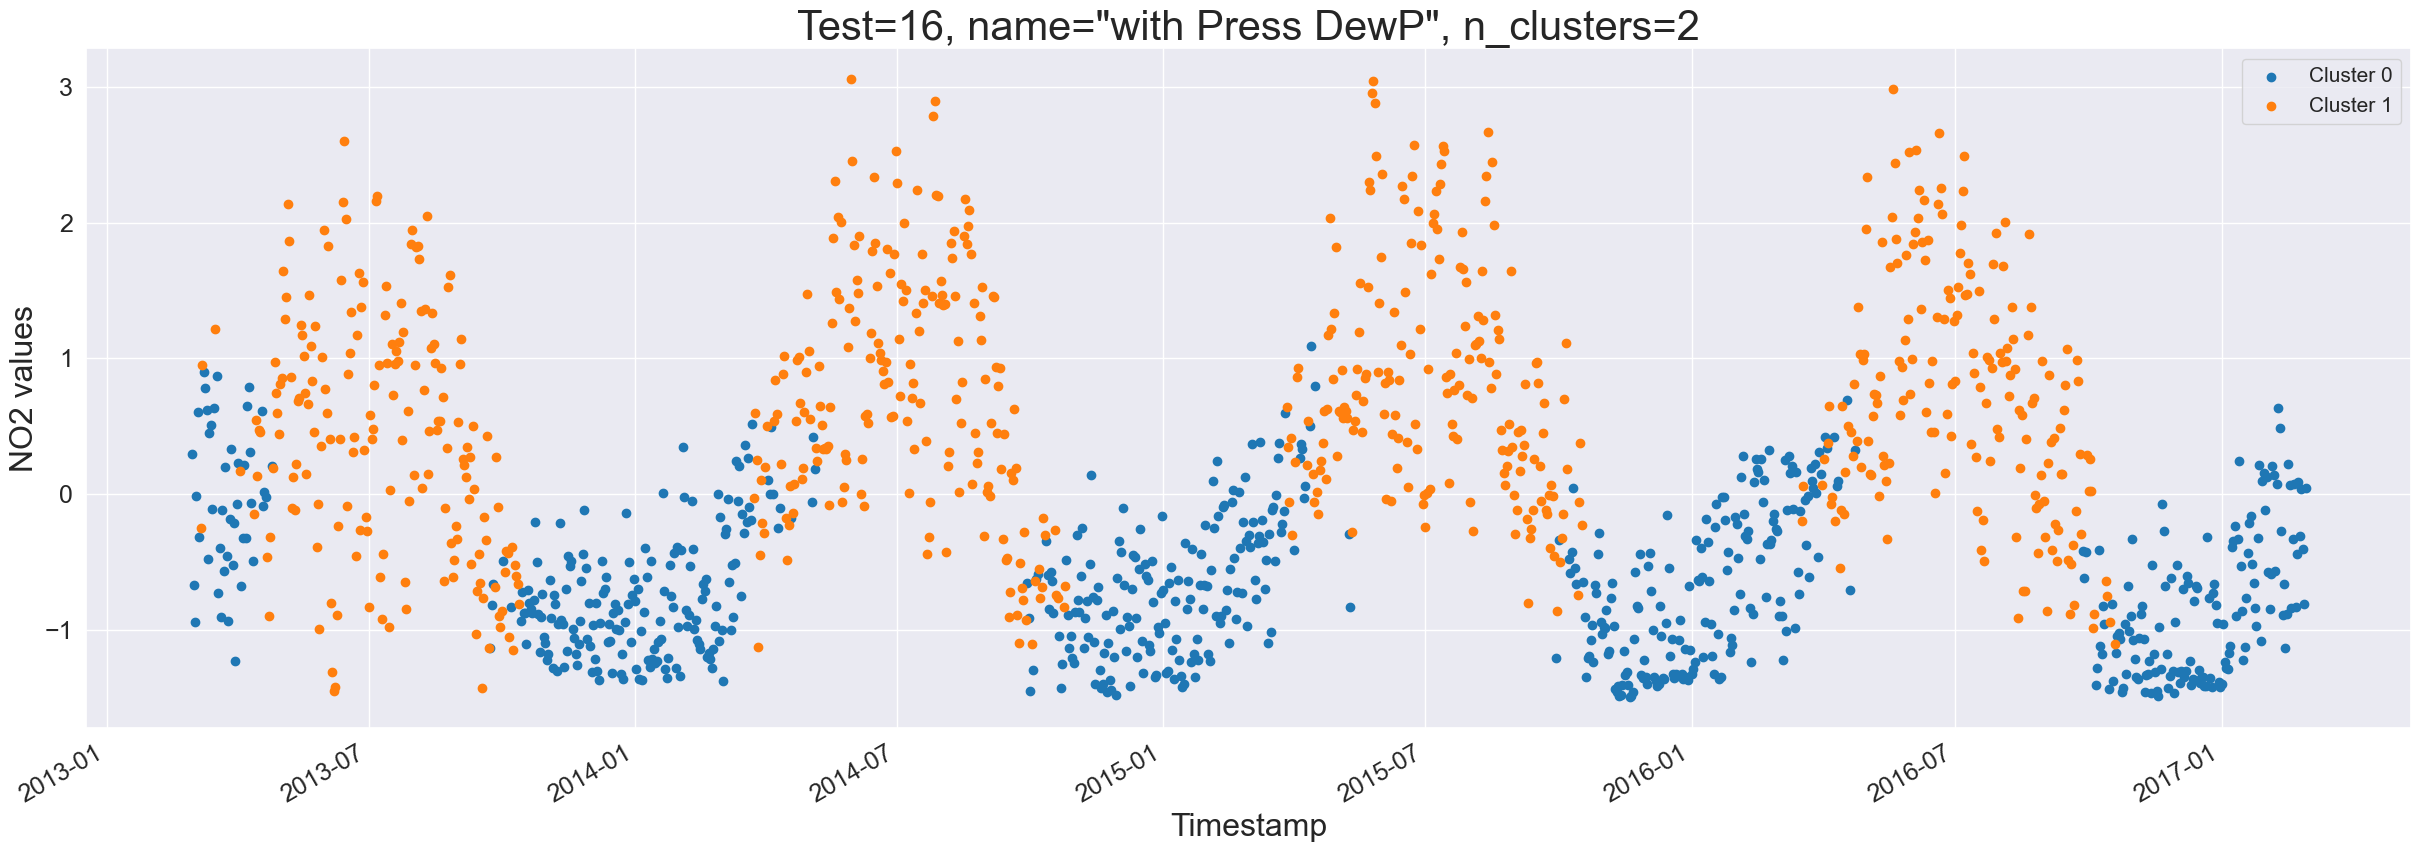

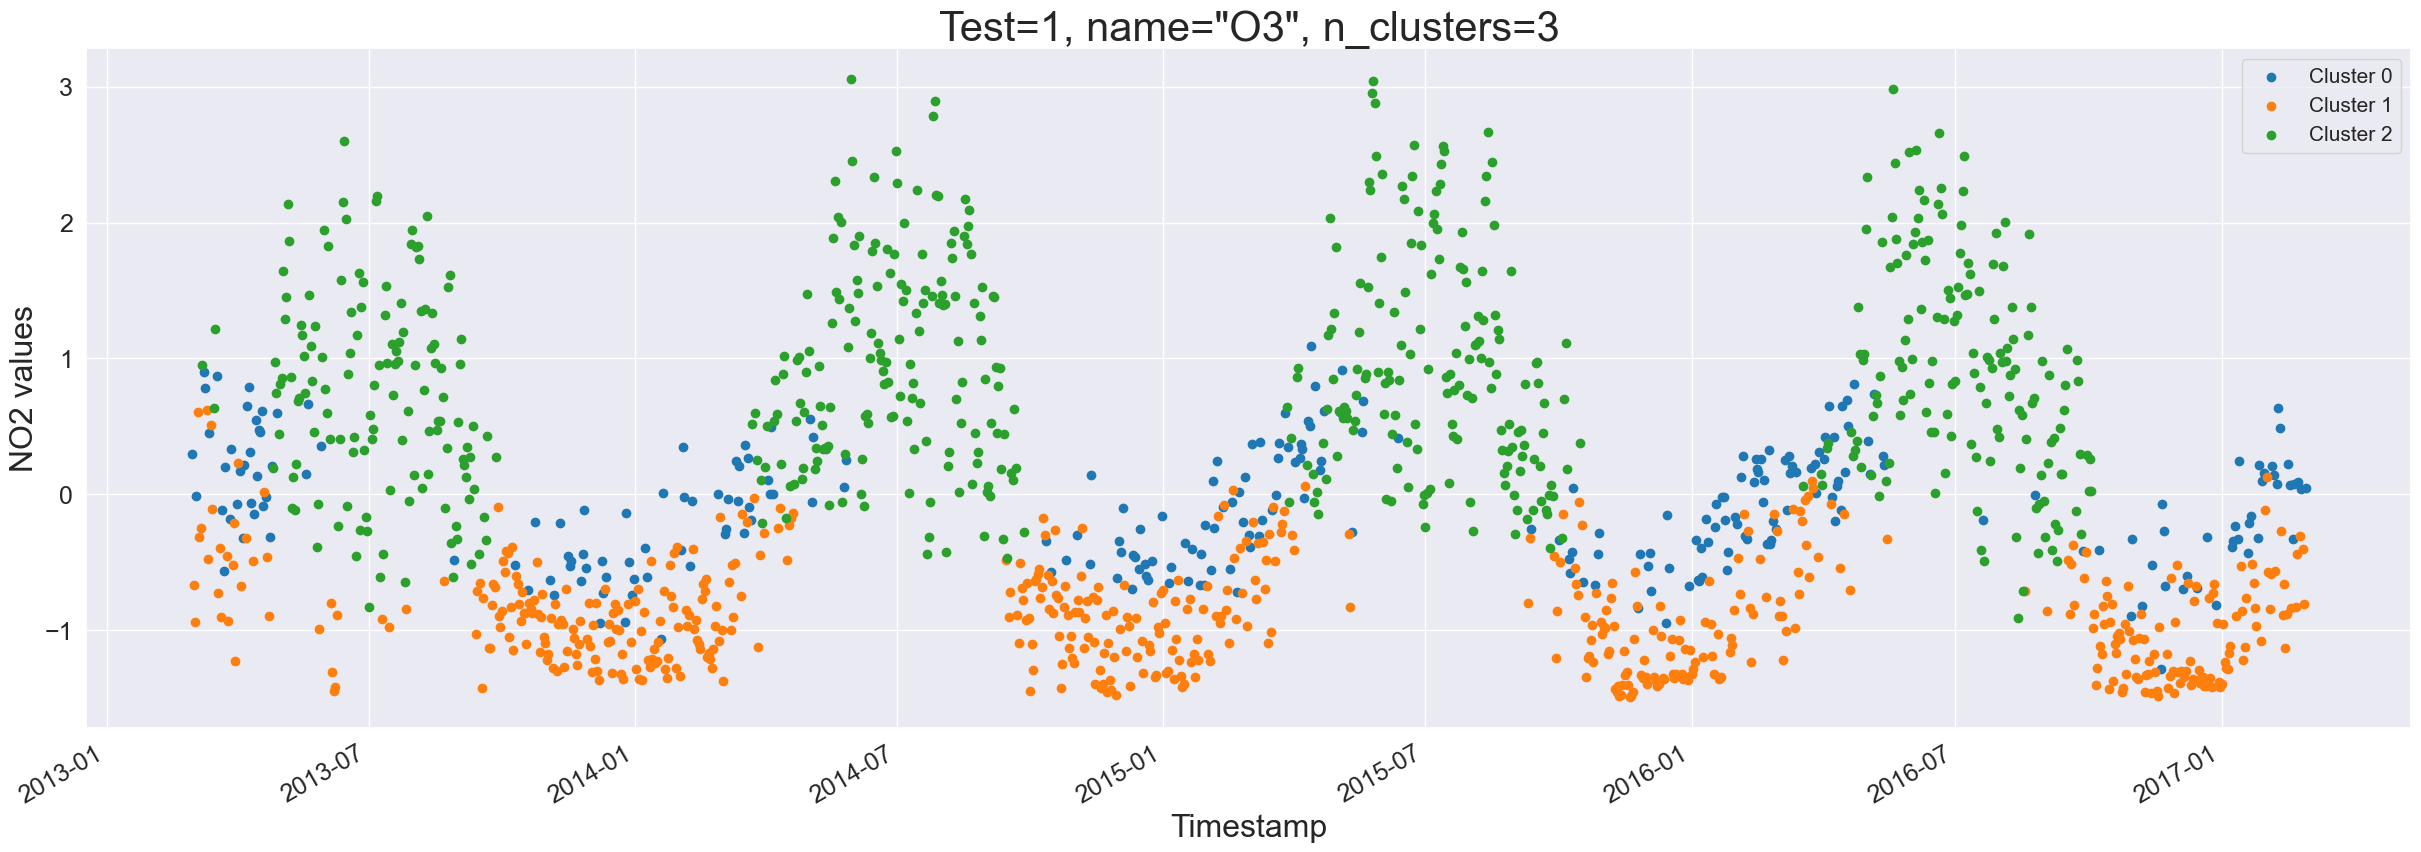

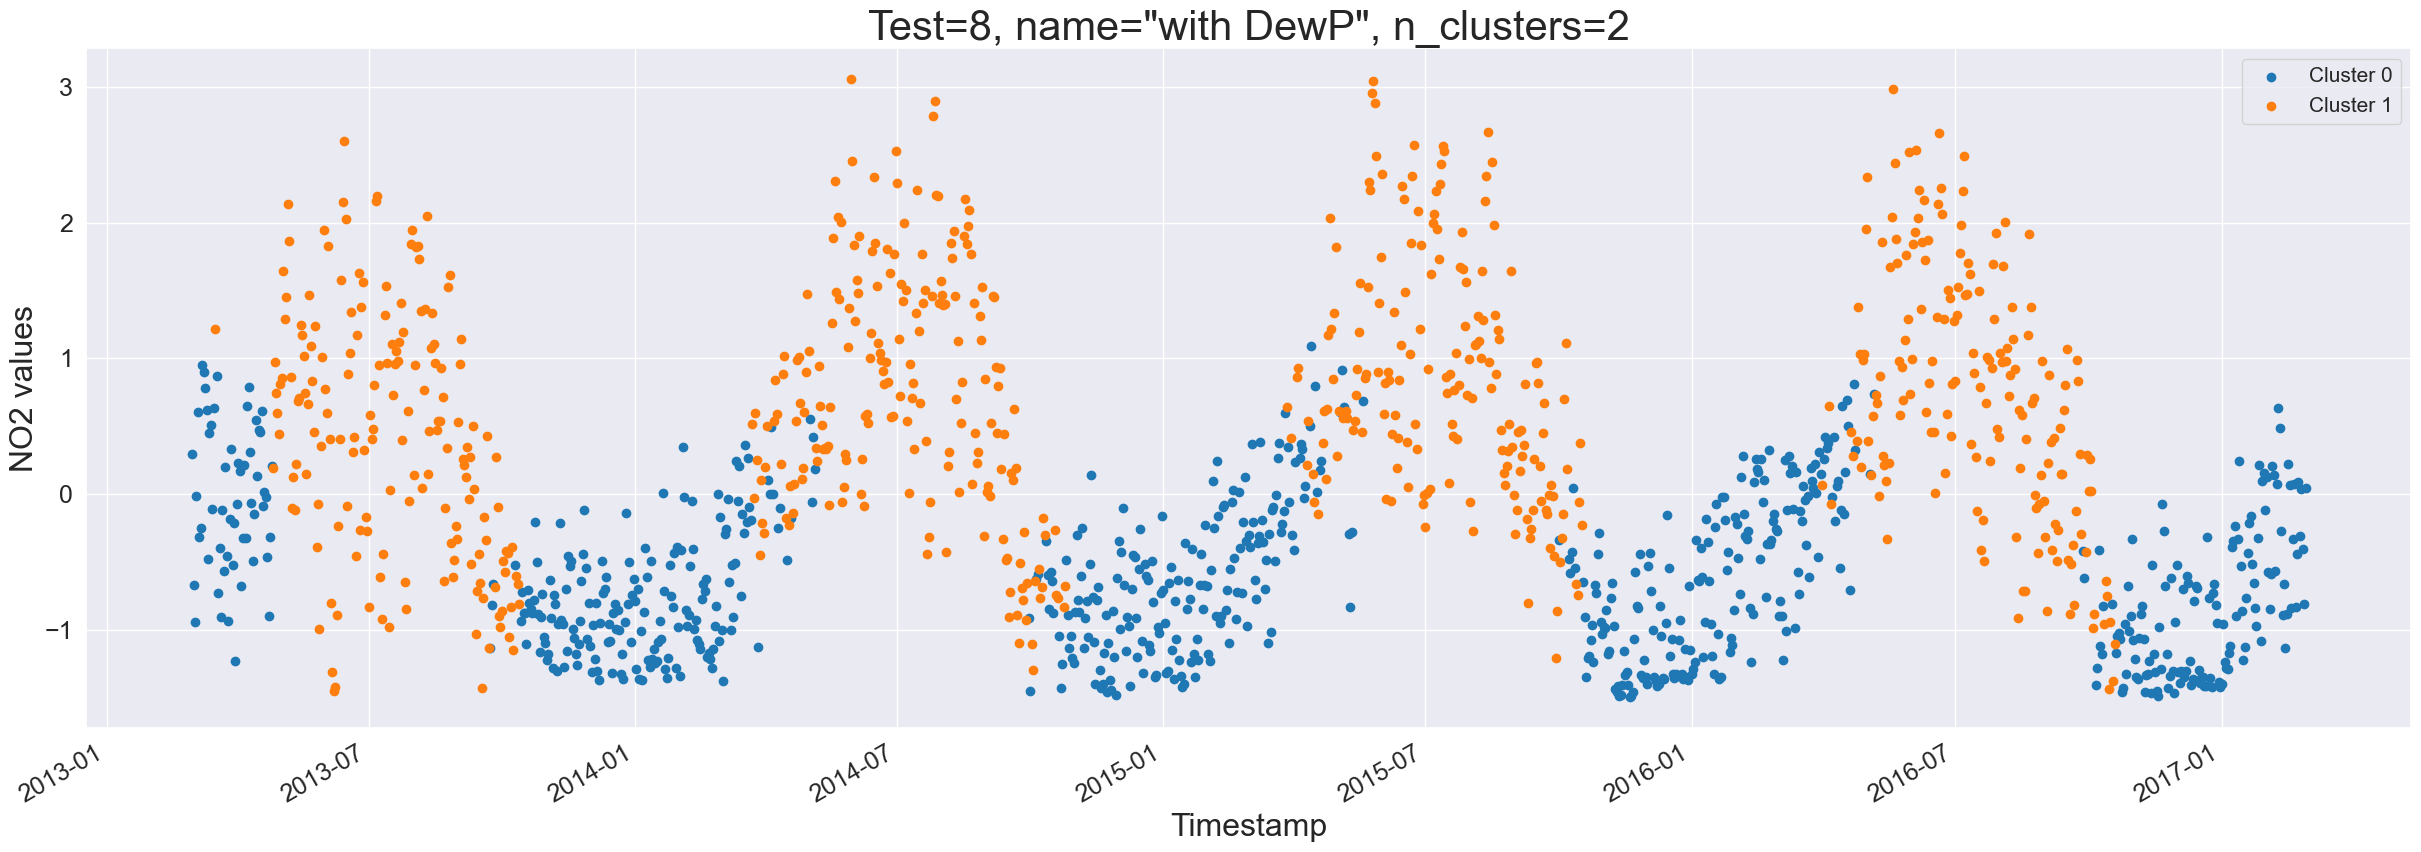

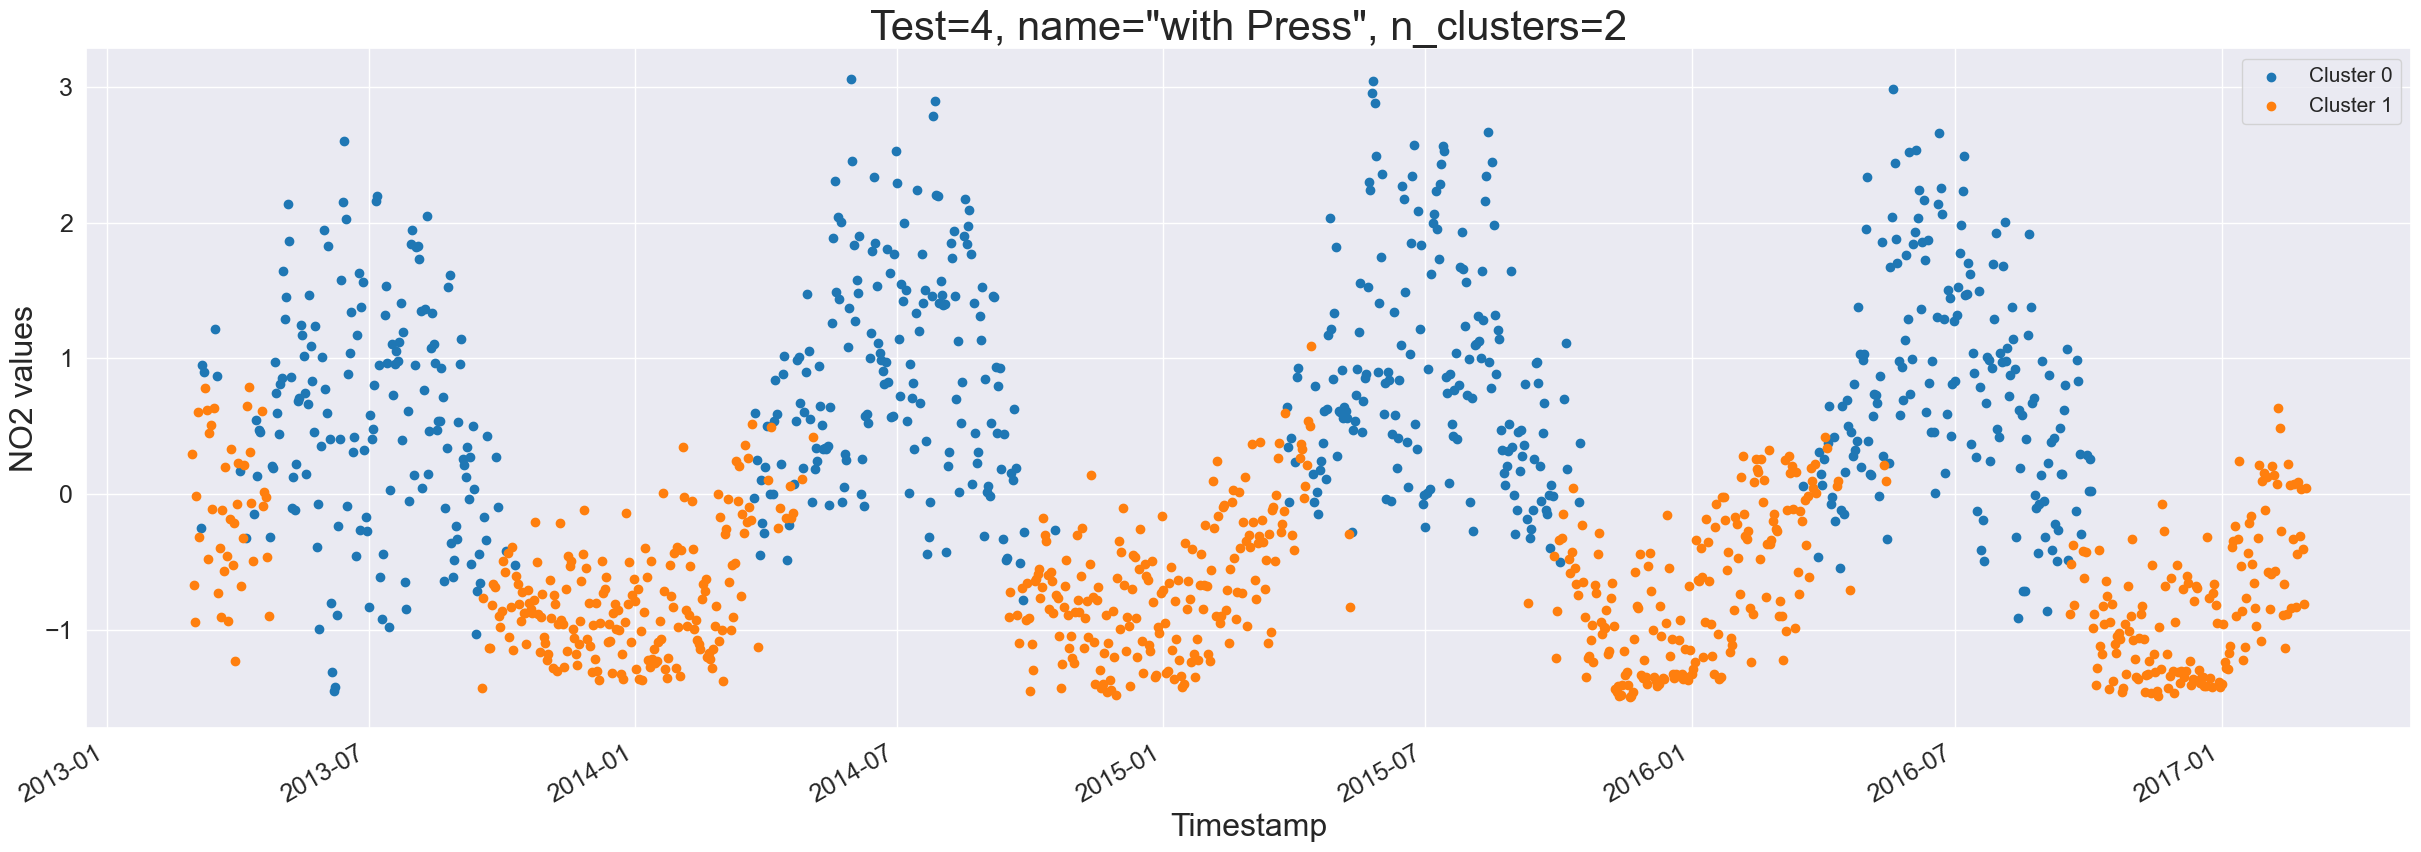

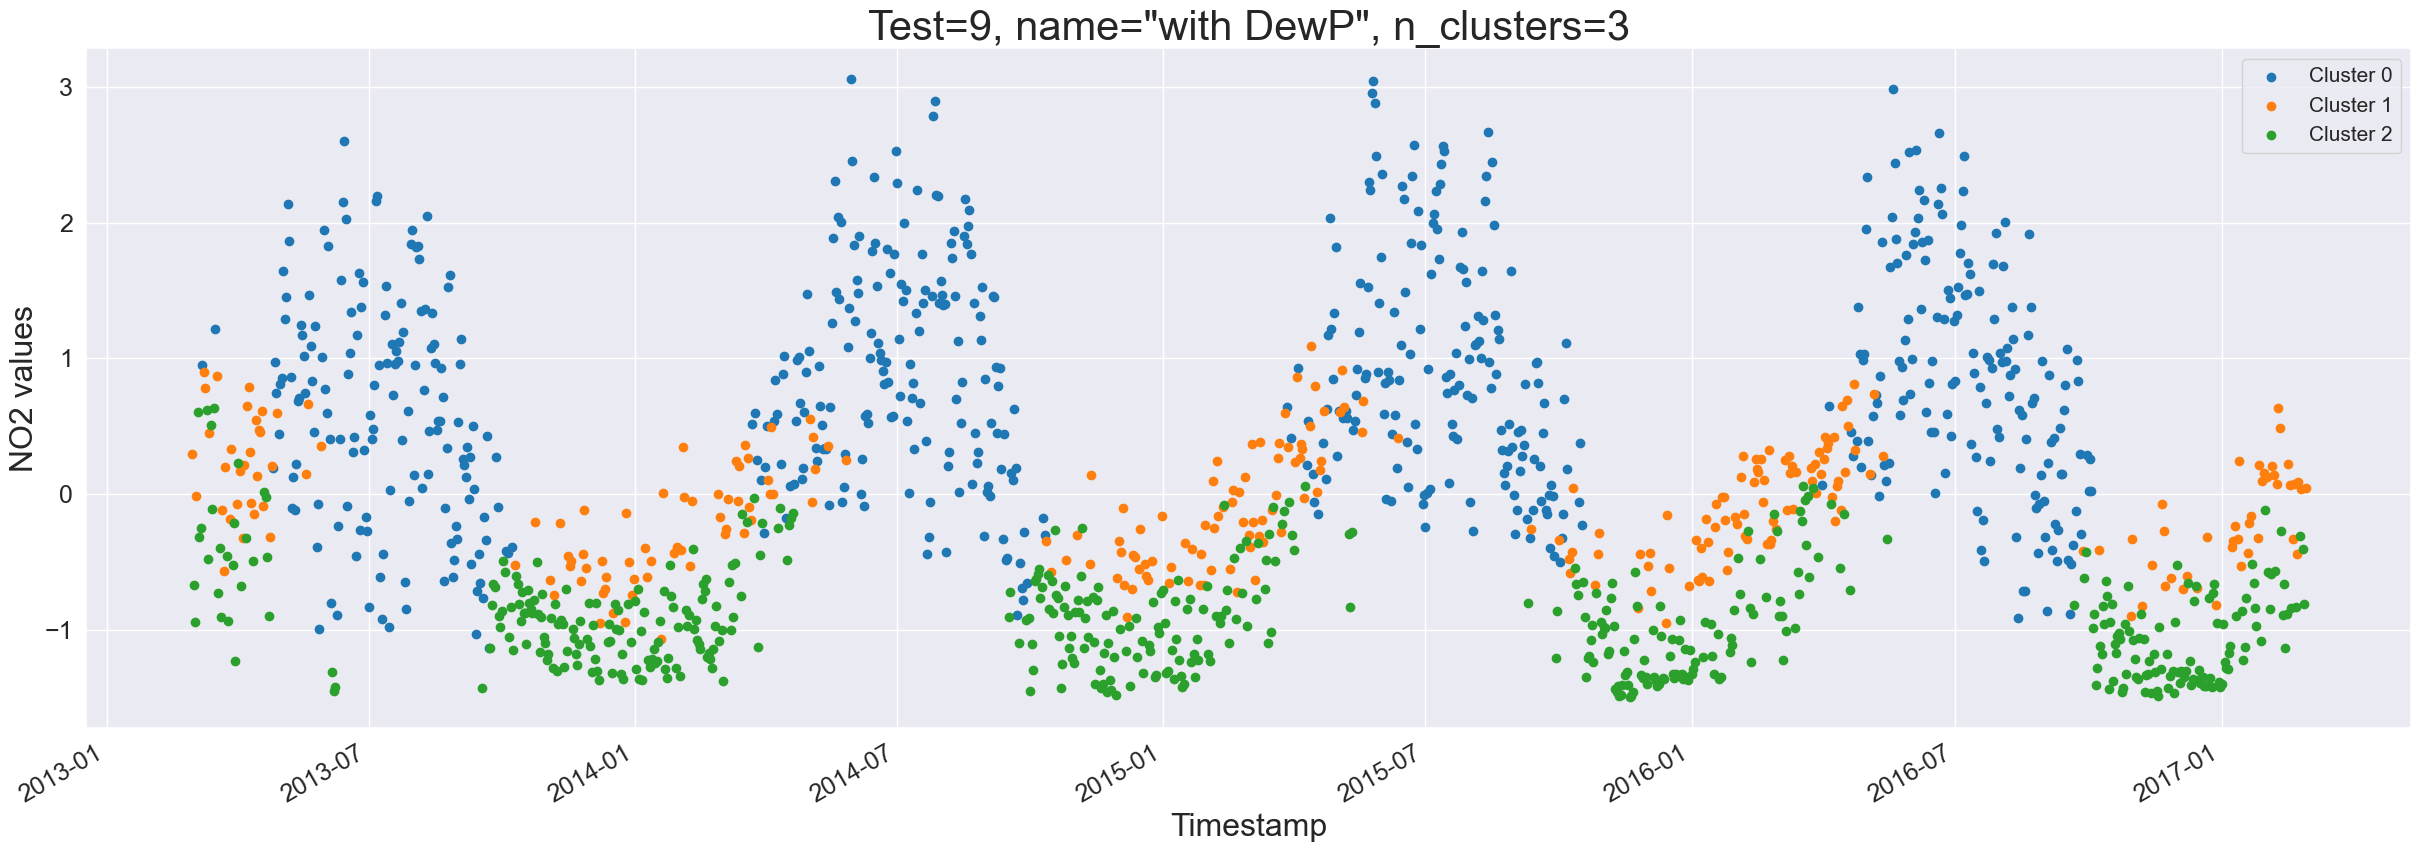

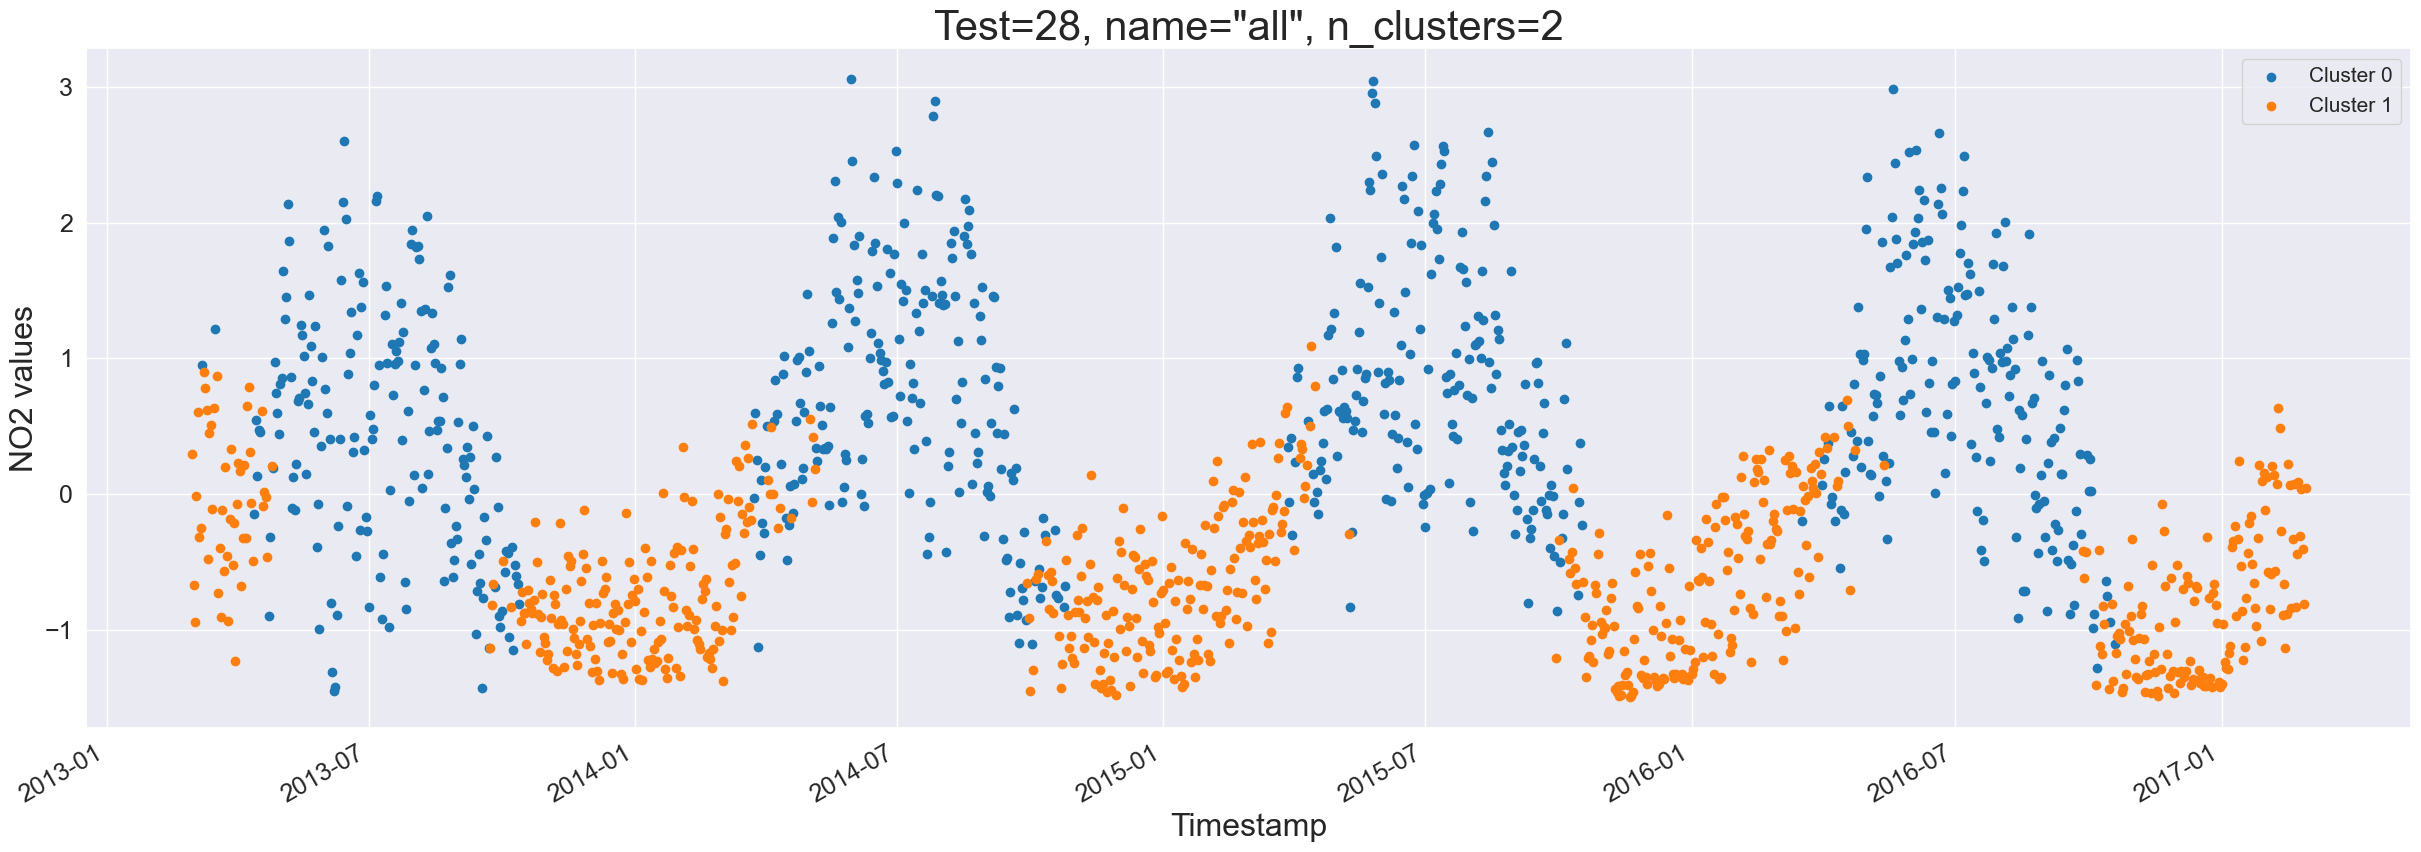

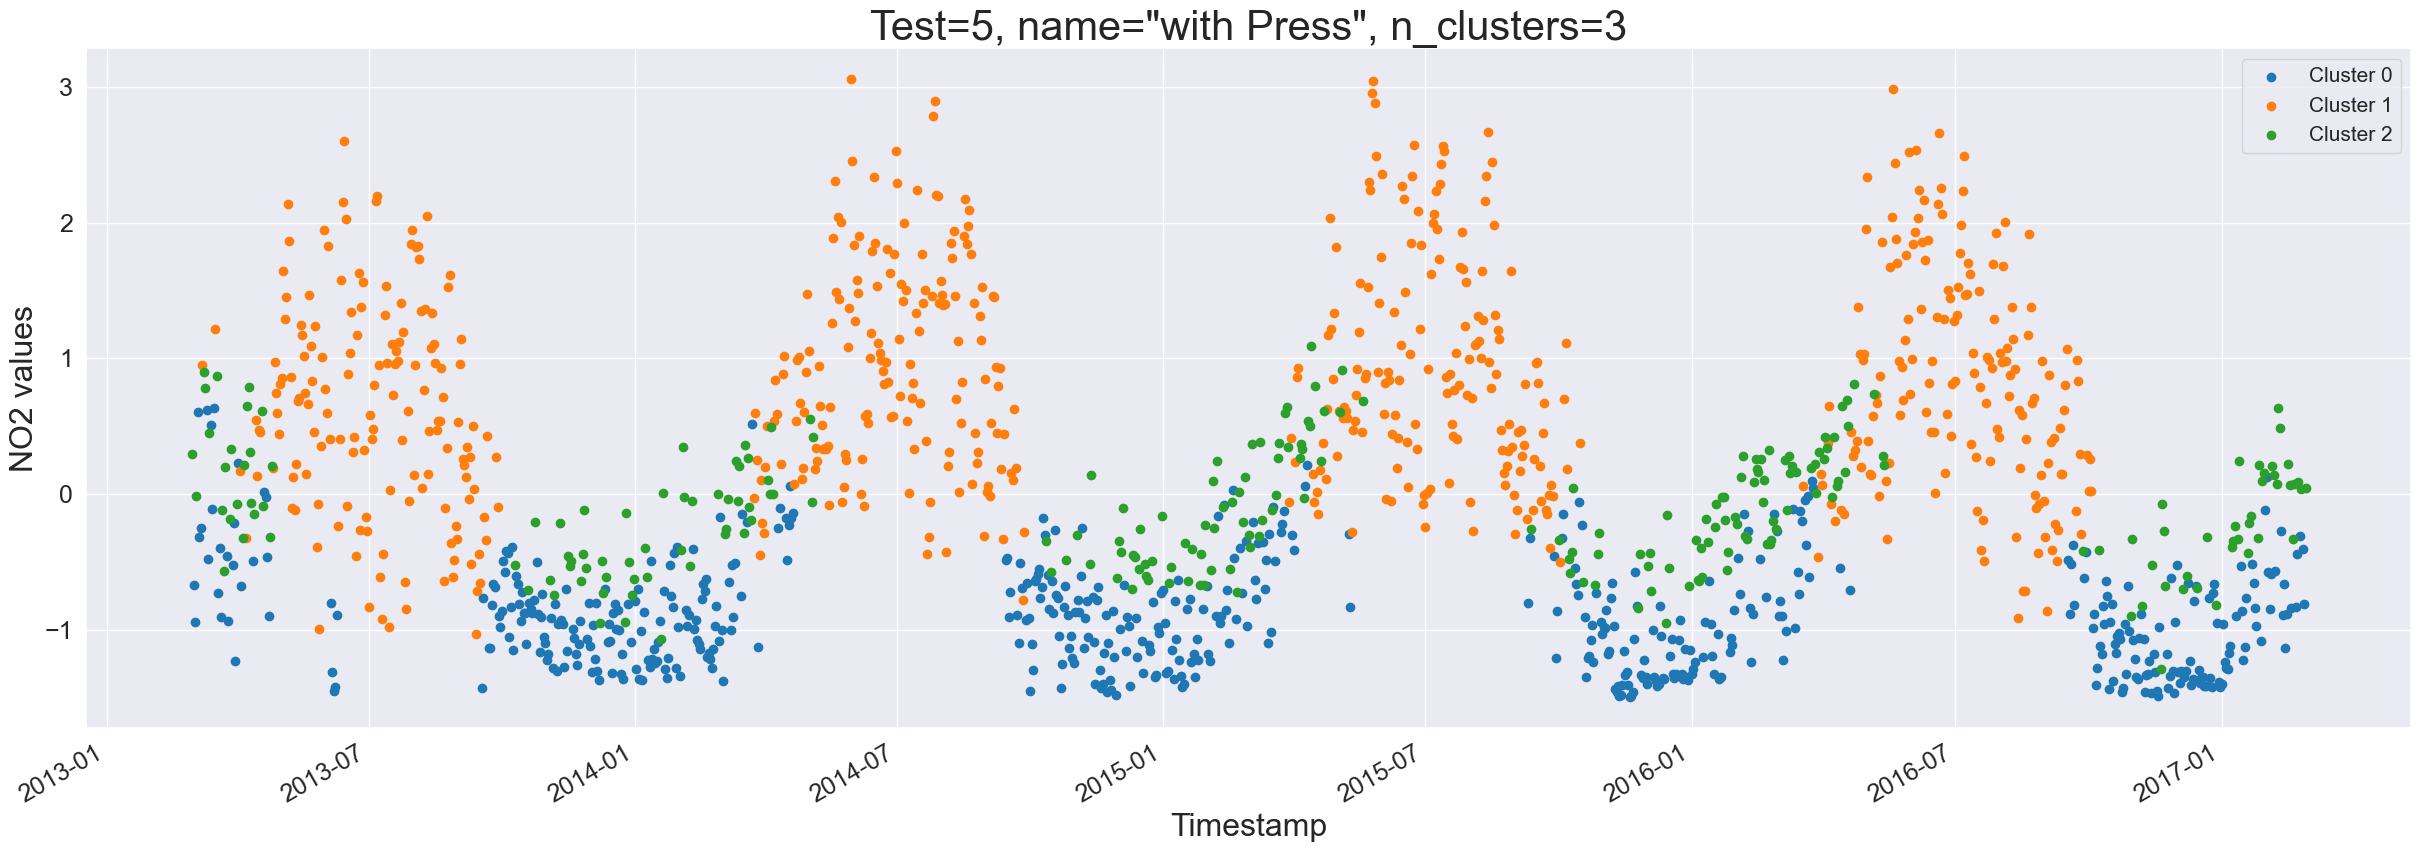

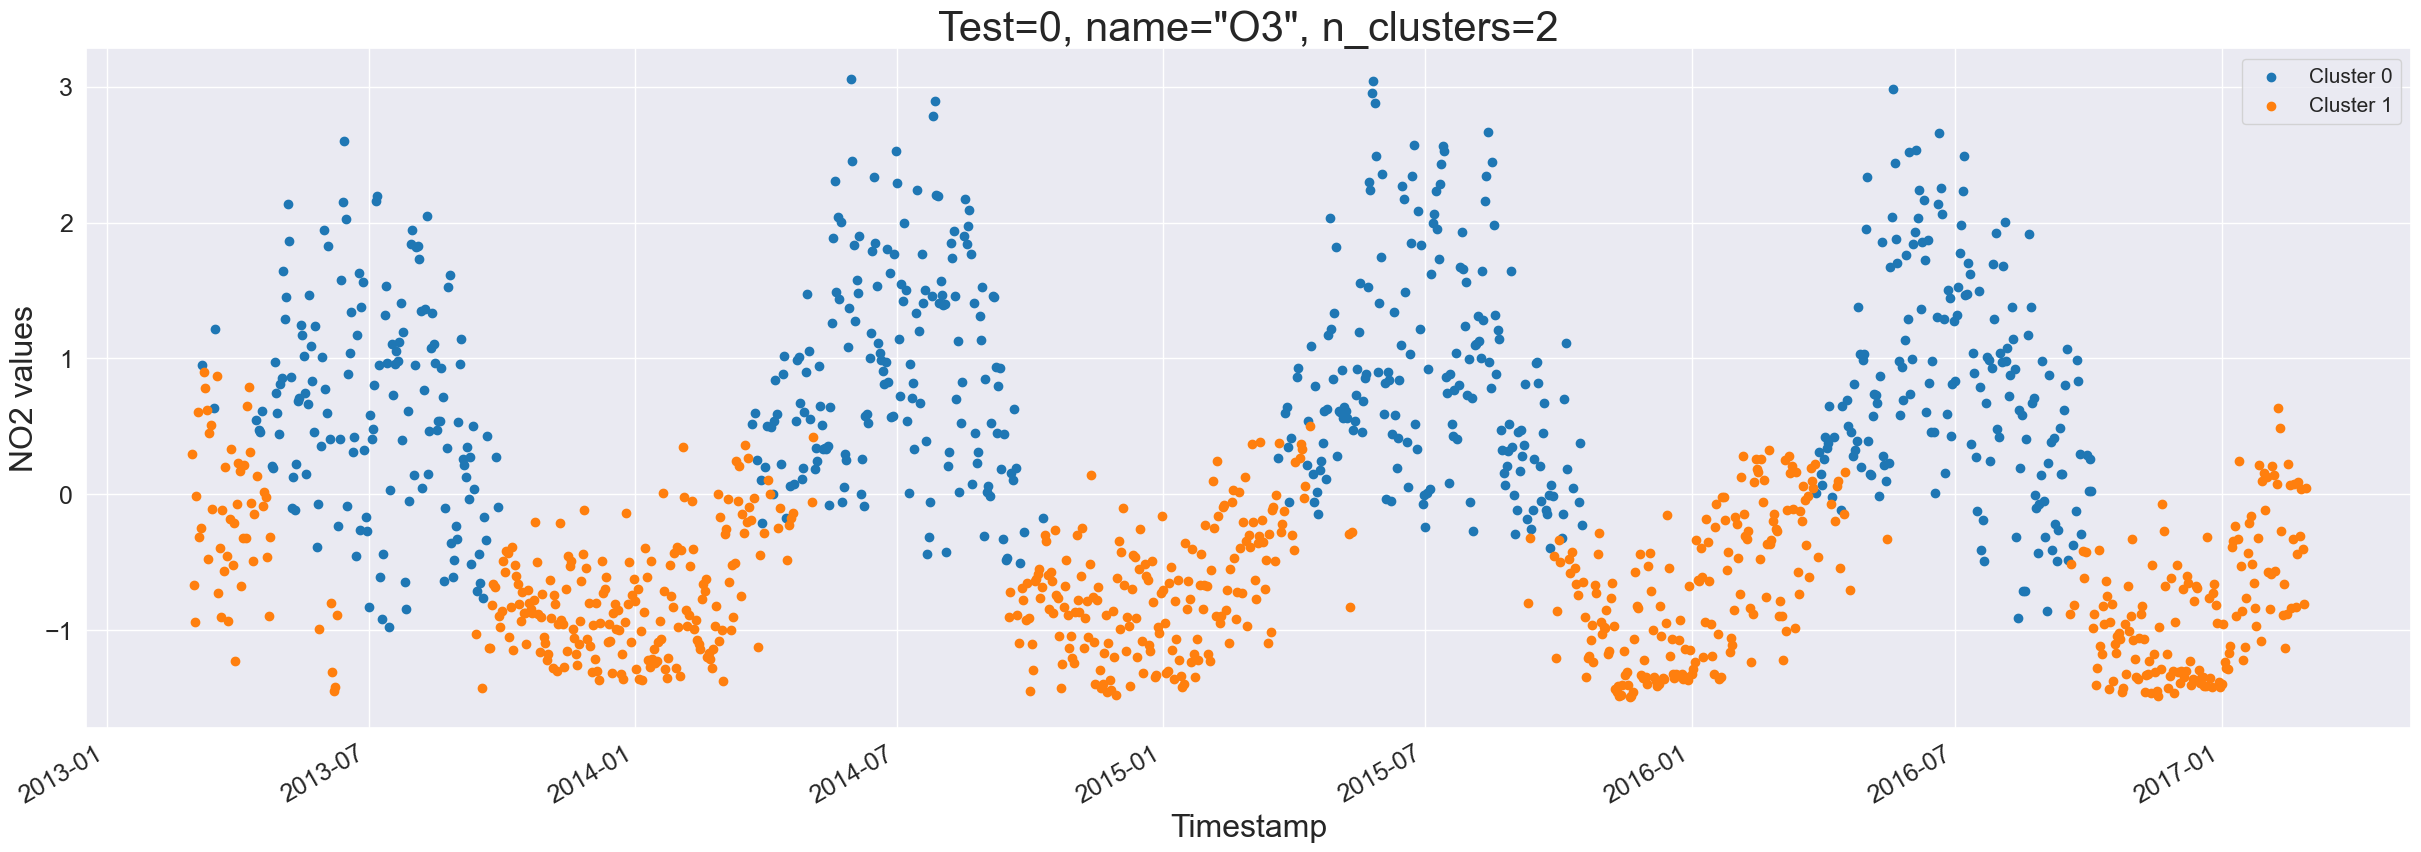

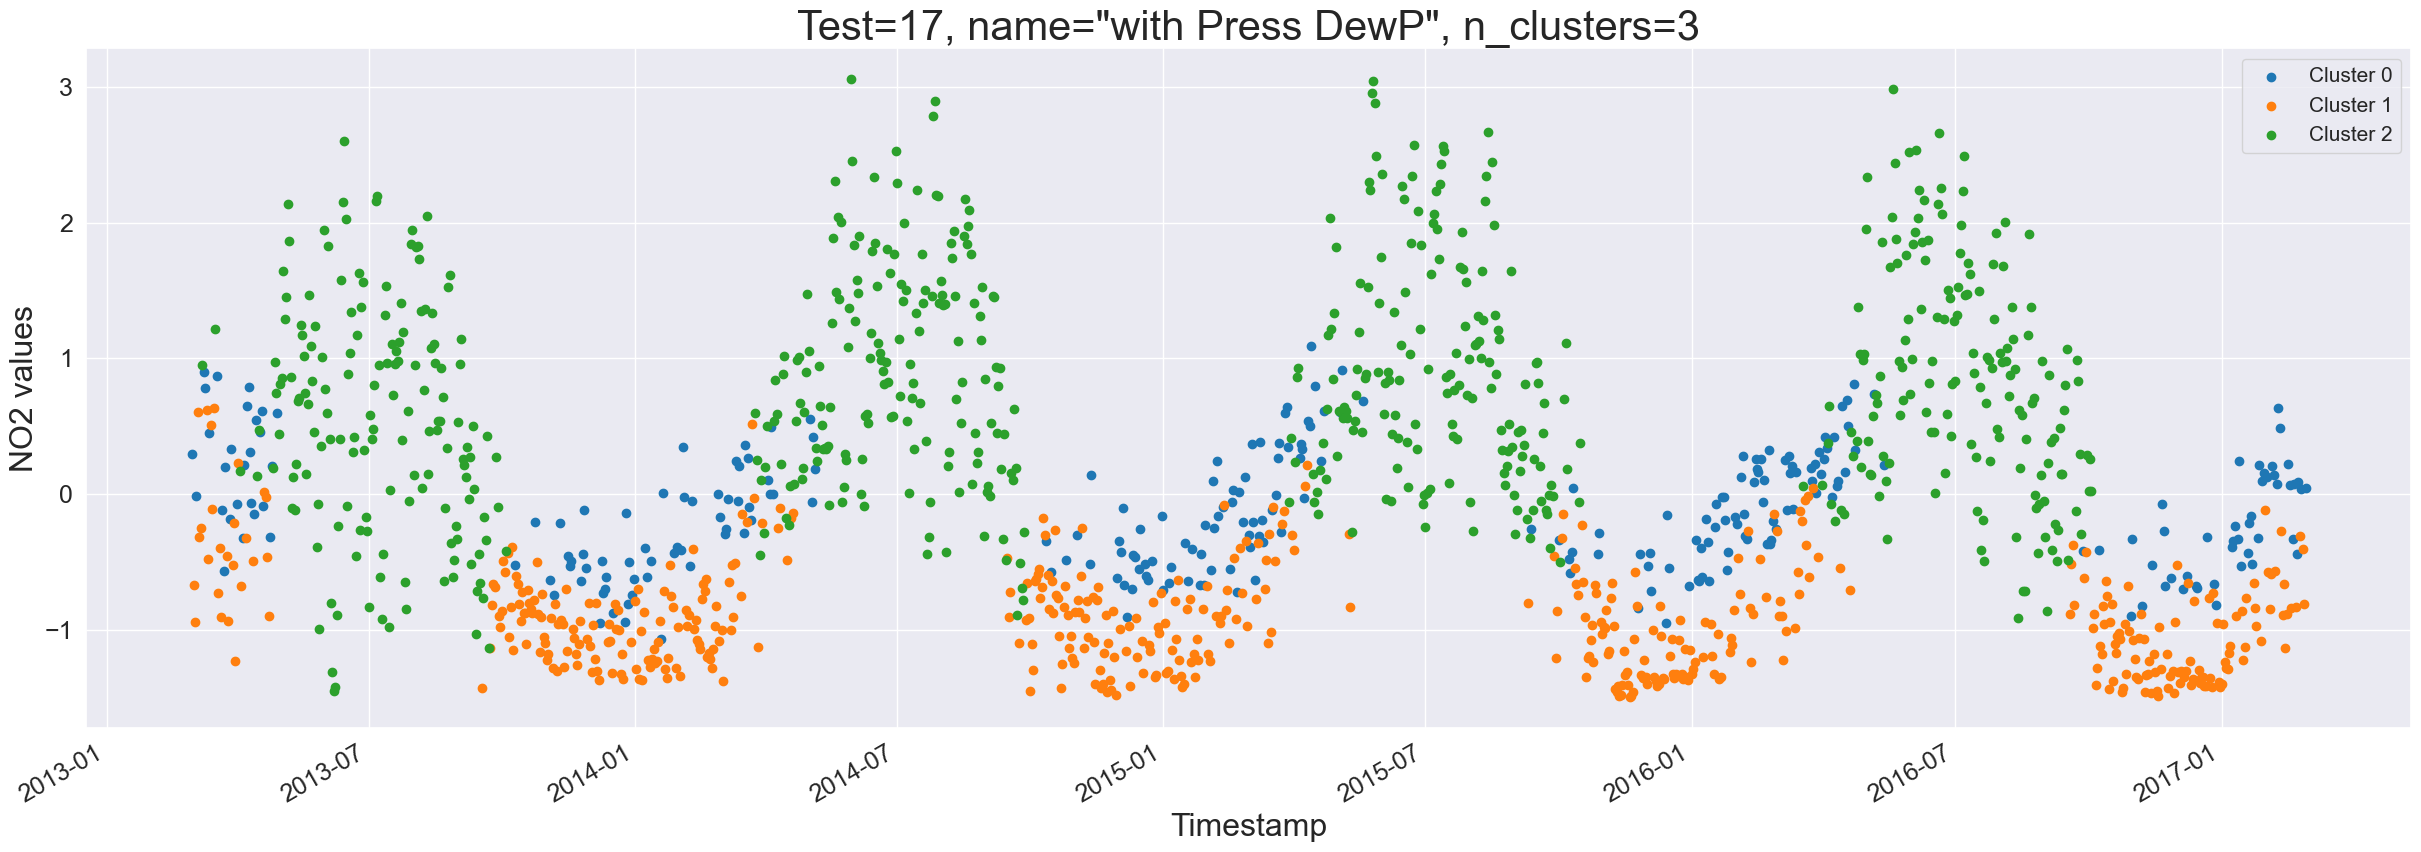

In [12]:
# Ploting clusters over the time series of the best models
for i in best_results.index:
    plot_ts_clusters_scatter(data_list[i], 'Test={}, name="{}", n_clusters={}'
                             .format(i, results.iloc[i, 0], results.iloc[i, 2]))